In [26]:
import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib         as mpl
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D
from invisible_cities.io import mcinfo_io as mio
from invisible_cities.io   .dst_io  import load_dst
from scipy import stats
import itertools
from next_sparseconvnet.data_io_scripts.plotting_utils import plot_projections, plot_3d_vox, plot_3d_hits

In [7]:
def plot_3d_vox(hits_digitized, value='energy', coords = ['x', 'y', 'z'], th=0, edgecolor=None, cmap=mpl.cm.jet):

    xmin, xmax = hits_digitized[coords[0]].min(), hits_digitized[coords[0]].max()
    ymin, ymax = hits_digitized[coords[1]].min(), hits_digitized[coords[1]].max()
    zmin, zmax = hits_digitized[coords[2]].min(), hits_digitized[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([hits_digitized[coords[0]].values-xmin+1, 
                          hits_digitized[coords[1]].values-ymin+1, 
                          hits_digitized[coords[2]].values-zmin+1])
    xarr[tuple(nonzeros)] = hits_digitized[value].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)

    plt.show()

def plot_3d_hits(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())
    
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)

    plt.show()

In [8]:
def read_event(fname, datid, table='Voxels', group='DATASET'):
    with tb.open_file(fname) as h5in:
        return pd.DataFrame.from_records(h5in.root[group][table].read_where('dataset_id==datid'))

## Plotting events from dataset

In [9]:
original_dataset = '/home/mmkekic/MC_dataset/new_data/valid_dataset.h5'
prediction_dataset = '/home/mperez/DNN_training/predictions/pred_file3.h5'

In [4]:
dataset_id = 50
original_event = read_event(original_dataset, dataset_id, table='Voxels') 
predicted_event = read_event(prediction_dataset, dataset_id, table='VoxelsPred') 

In [5]:
original_event.head()

,xbin,ybin,zbin,energy,segclass,binclass,dataset_id
0,169,123,274,0.002139,1,0,50
1,181,120,266,0.008799,1,0,50
2,169,123,275,0.008292,1,0,50
3,140,136,279,0.004418,1,0,50
4,177,132,283,0.002771,1,0,50


In [6]:
predicted_event.head()

,label,energy,dataset_id,xbin,ybin,zbin,class_0,class_1,class_2
0,1,0.002139,50,169,123,274,0.046921,0.951817,0.001262
1,1,0.008799,50,181,120,266,0.045592,0.953212,0.001196
2,1,0.008292,50,169,123,275,0.062317,0.936291,0.001391
3,1,0.004418,50,140,136,279,0.046547,0.871332,0.082121
4,1,0.002771,50,177,132,283,0.044005,0.955631,0.000363


In [7]:
#add maxprediction to predicted_event
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1', 'class_2']].values, axis=-1))

In [8]:
predicted_event.head()

,label,energy,dataset_id,xbin,ybin,zbin,class_0,class_1,class_2,pred
0,1,0.002139,50,169,123,274,0.046921,0.951817,0.001262,1
1,1,0.008799,50,181,120,266,0.045592,0.953212,0.001196,1
2,1,0.008292,50,169,123,275,0.062317,0.936291,0.001391,1
3,1,0.004418,50,140,136,279,0.046547,0.871332,0.082121,1
4,1,0.002771,50,177,132,283,0.044005,0.955631,0.000363,1


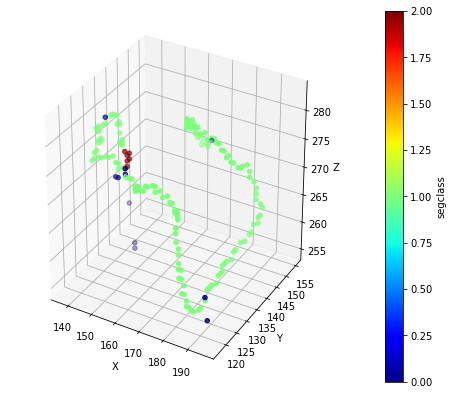

In [9]:
plot_3d_hits(original_event, value='segclass', coords = ['xbin', 'ybin', 'zbin'],  cmap = mpl.cm.jet)

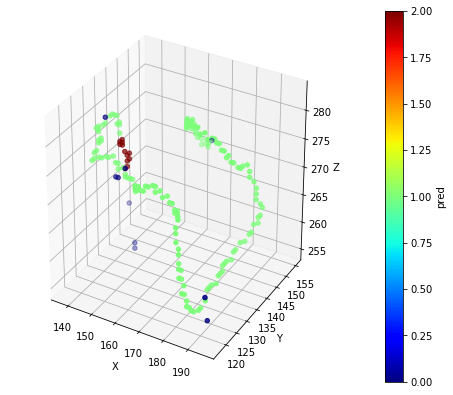

In [10]:
plot_3d_hits(predicted_event, value='pred', coords = ['xbin', 'ybin', 'zbin'])

In [70]:
#for voxel plotting extract the main path volume only
def get_path_volume(df, label):
    dfp = df[df[label]==1][['xbin', 'ybin', 'zbin']]
    xmin, xmax = dfp.xbin.min(), dfp.xbin.max()
    ymin, ymax = dfp.ybin.min(), dfp.ybin.max()
    zmin, zmax = dfp.zbin.min(), dfp.zbin.max()
    volum = df.xbin.between(xmin-5, xmax+5) & df.ybin.between(ymin-5, ymax+5) & df.zbin.between(zmin-5, zmax+5)
    return df[volum]

In [71]:
org_shrinked = get_path_volume(original_event, label='segclass')
pred_shrinked = get_path_volume(predicted_event, label='pred')

In [90]:
dataset_id = 8#np.random.randint(5000)
print(dataset_id)
original_event = read_event(original_dataset, dataset_id, table='Voxels') 
predicted_event = read_event(prediction_dataset, dataset_id, table='VoxelsPred') 
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1', 'class_2']].values, axis=-1))
org_shrinked = get_path_volume(original_event, label='segclass')
pred_shrinked = get_path_volume(predicted_event, label='pred')

8


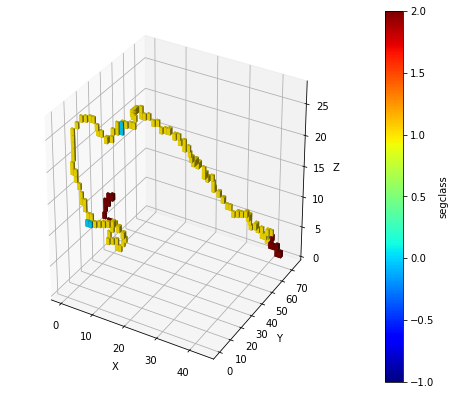

In [91]:
plot_3d_vox(org_shrinked, value='segclass', coords = ['xbin', 'ybin', 'zbin'], th = -1)

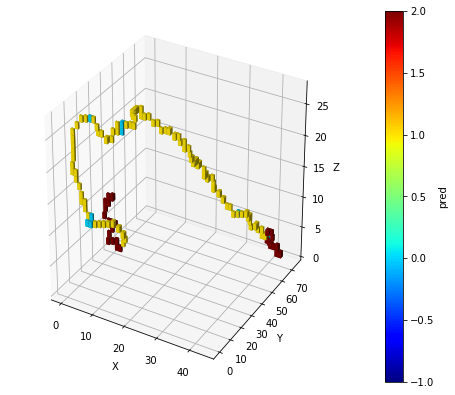

In [92]:
plot_3d_vox(pred_shrinked, value='pred', coords = ['xbin', 'ybin', 'zbin'], th=-1)

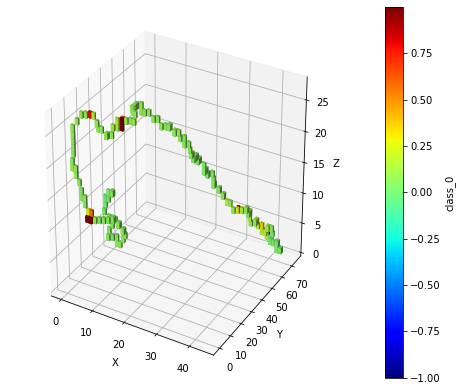

In [95]:
plot_3d_vox(pred_shrinked, value='class_0', coords = ['xbin', 'ybin', 'zbin'], th=-1)

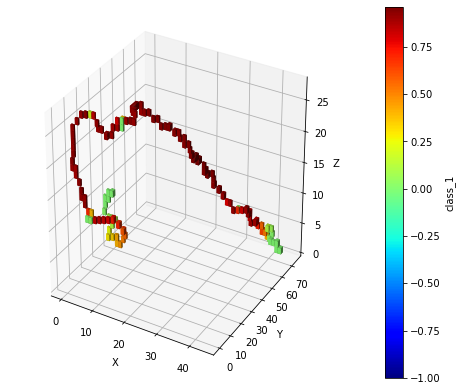

In [96]:
plot_3d_vox(pred_shrinked, value='class_1', coords = ['xbin', 'ybin', 'zbin'], th=-1)

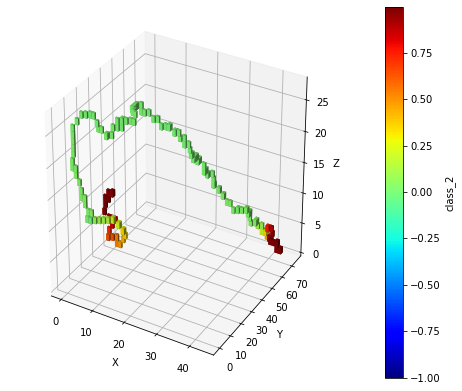

In [97]:
plot_3d_vox(pred_shrinked, value='class_2', coords = ['xbin', 'ybin', 'zbin'], th=-1)

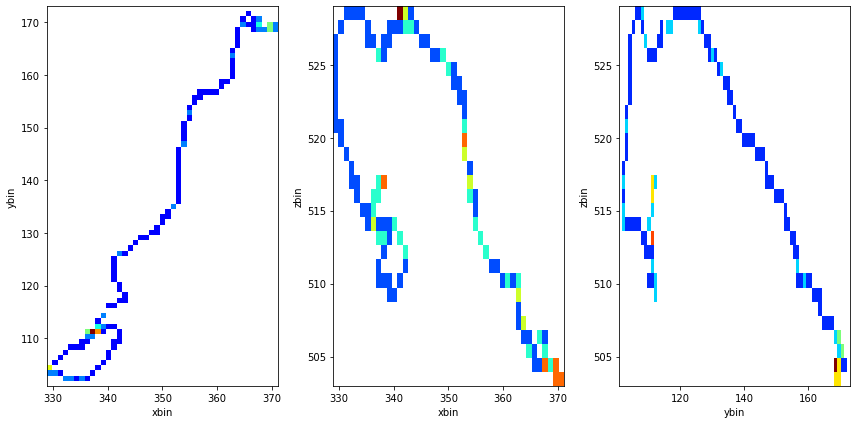

In [93]:
plot_projections(org_shrinked, value = 'segclass', coords = ['xbin', 'ybin', 'zbin'])

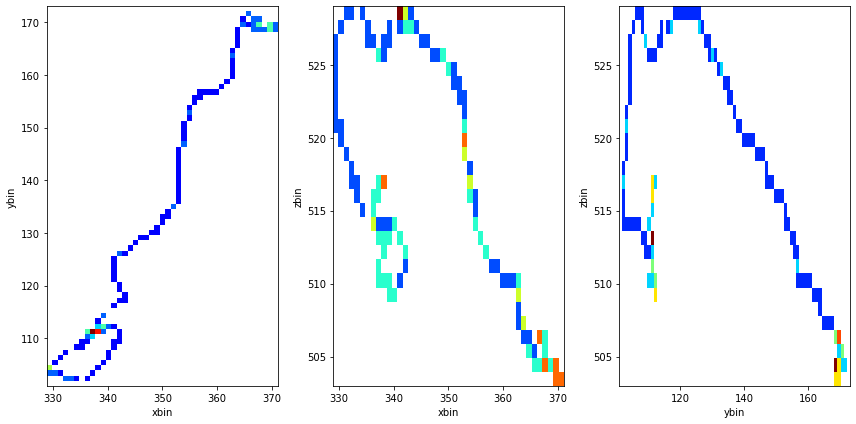

In [94]:
plot_projections(pred_shrinked, value = 'pred', coords = ['xbin', 'ybin', 'zbin'])

# Mirroring/rotating data

In [10]:
train_data = '/home/mmkekic/MC_dataset/new_data/train_dataset_all.h5'

In [11]:
#this function doesnt work well for every event, its corrected by marija in github
def transform_input(original_hits, bin_max):
    bin_names = ['xbin', 'ybin', 'zbin']
    
    #mirroring in x, y and z
    for n, m in zip(bin_names, bin_max):
        if np.random.randint(2) == 1:
            original_hits[n] = m - original_hits[n]
    
    #rotating 90 degrees
    if np.random.randint(2) == 1:
        x1, x2 = np.random.choice(3, size = 2, replace = False) #chooses randomly the 2 coord and the direction of the rotation
        names   = [bin_names[x1], bin_names[x2]]
        maxbin  = [bin_max[x1], bin_max[x2]]
        
        hits    = [original_hits[names[1]].copy(), maxbin[0] - original_hits[names[0]]]
        
        for i, m in enumerate(maxbin):
            if max(hits[i])>m:
                minbin = min(hits[i])
                hits[i] = hits[i] - minbin
                if max(hits[i])>m: #if after the translation it's still larger than it should, rotation doesn't occur
                    return
        
        original_hits[names[0]] = hits[0]
        original_hits[names[1]] = hits[1]
    
    return

In [28]:
from next_sparseconvnet.utils.data_loaders import transform_input

In [107]:
def transform_input(hits, bin_max, inplace=True):
    bin_names = ['xbin', 'ybin', 'zbin']

    if not inplace:
        hits = hits.copy()
    '''
    #mirroring in x, y and z
    for n, m in zip(bin_names, bin_max):
        if np.random.randint(2) == 1:
            hits[n] = m - hits[n]
            print('Mirror for '+ n)
    '''
    def possible_rotations(element):
        x1, x2 = element
        return ((hits[bin_names[x1]].max()-hits[bin_names[x1]].min()<=bin_max[x2]) and
                (hits[bin_names[x2]].max()-hits[bin_names[x2]].min()<=bin_max[x1]))
    if np.random.randint(2) == 1:
        rotations_list = list(filter(possible_rotations, itertools.permutations([0, 1, 2], 2)))
        x1, x2 = rotations_list[np.random.randint(len(rotations_list))]
        names   = [bin_names[x1], bin_names[x2]]
        maxbin  = [bin_max[x1], bin_max[x2]]
        #rotate hits
        hits[names] = hits[names[::-1]]
        #flip second axis; this can make bins negative cause maxbin[x1]!=maxbin[x2]
        hits[names[1]] = maxbin[1]-hits[names[1]]
        #substract (max_index - maxbin) if it is positive for x1
        hits[names[0]]-= max(hits[names[0]].max()-maxbin[0], 0)
        #substract min of 0 and min(hits[names[1]]) to ensure bins are positive for x2
        hits[names[1]]-= min(hits[names[1]].min(), 0)
        
        print('Rotation for', x1, x2)
    if not inplace:
        return hits

In [77]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_projections(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet, th = 0):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    
    coors_pairs = itertools.combinations(coords, 2)
    cmap.set_under('white')
    for i, coor_pair in enumerate(coors_pairs):        
        sel = hits.groupby(list(coor_pair))[value].sum()
        ind0 = sel.index.get_level_values(coor_pair[0])
        ind1 = sel.index.get_level_values(coor_pair[1])
        newind0 = np.arange(ind0.min(), ind0.max()+1)
        newind1 = np.arange(ind1.min(), ind1.max()+1)
        xx, yy = np.meshgrid(newind0, newind1)
        newind = pd.Index(list(zip(xx.flatten(), yy.flatten())), name=tuple(coor_pair))
        sel = sel.reindex(newind,  fill_value=0).reset_index()
        sel = pd.pivot_table(sel, values=value, index=[coor_pair[0]],
                        columns=[coor_pair[1]], aggfunc=np.sum)
        #print((newind0.min(),newind0.max(), newind1.min(),  newind1.max()))
        m = axs[i].imshow(sel.T, origin='lower', vmin=th+np.finfo(float).eps, extent=(newind0.min(),newind0.max(), newind1.min(),  newind1.max()),
                      cmap=cmap, aspect='auto')
        axs[i].set_xlabel(coor_pair[0])
        axs[i].set_ylabel(coor_pair[1])
        
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size='5%', pad=0.05, label = value)
        fig.colorbar(m, cax=cax, orientation='vertical')
    
    
    fig.tight_layout()

In [109]:
h5in = tb.open_file(train_data, 'r')
di = 644244
hits  = h5in.root.DATASET.Voxels.read_where('dataset_id==di')
bininfo    = load_dst(train_data, 'DATASET', 'BinsInfo')
maxbins = [bininfo['nbins_x'][0], bininfo['nbins_y'][0], bininfo['nbins_z'][0]]

original_hits = pd.DataFrame.from_records(hits)
transform_input(hits, maxbins)
mod_hits = pd.DataFrame.from_records(hits)

Rotation for 2 1


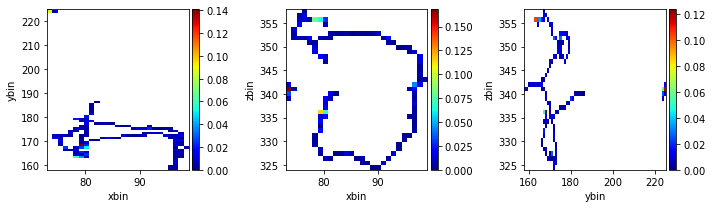

In [110]:
%matplotlib inline
plot_projections(original_hits, value = 'energy', coords = ['xbin', 'ybin', 'zbin'])

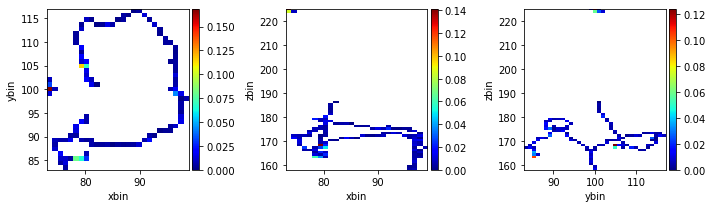

In [111]:
plot_projections(mod_hits, value = 'energy', coords = ['xbin', 'ybin', 'zbin'])

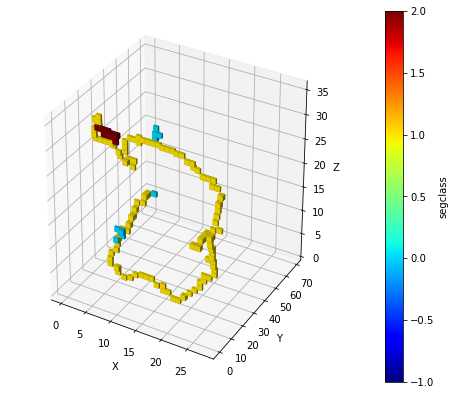

In [113]:
%matplotlib inline
plot_3d_vox(original_hits, value='segclass', coords = ['xbin', 'ybin', 'zbin'], th = -1)

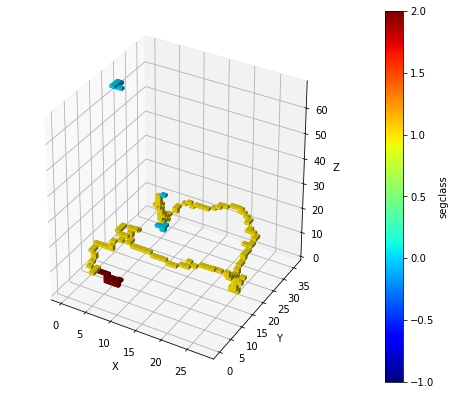

In [114]:
plot_3d_vox(mod_hits, value='segclass', coords = ['xbin', 'ybin', 'zbin'], th = -1)